## 1. Mount Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2. Split folders with images into train and test folders.

In [ ]:
# !pip install split-folders
# import split_folders
# pre_data_dir = '/content/drive/My Drive/color/'
# data_dir = '/content/drive/My Drive/color_split/'
# split_folders.ratio(pre_data_dir, output=data_dir, seed=1337, ratio=(.1, .9))

## 3. Build a Deep Learning model using a pretrained model 

We choose **AlexNet** model and use a Feature Extraction Transfer Learning to train it and build our model. We will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

### 3.1. Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import os
import time
import copy

### 3.2. Specify the input parameters

In [ ]:
# The format of the data directory conforms to the ImageFolder structure
data_dir = '/content/drive/My Drive/PlantVillage/raw/color_split/'
# data_dir = os.getcwd()+'/PlantVillage/raw/color_split/'


# A CNN model to choose 
model_name = 'alexnet'

# Number of classes in the dataset
num_classes = 38

# Batch size for training (change depending on how much memory you have)
batch_size = 134

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When True we only update the reshaped layer params
feature_extract = True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

### 3.3. Load data

In [ ]:
# Training: Data aumentation and normalization
# Validation: Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

print("Initializing Traning and Validation Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Traning and Validation Datasets and Dataloaders...


In [ ]:
device

device(type='cuda', index=0)

### 3.4 Choose, reshape, and initialize a model (i.e., AlexNet) 

In [ ]:
def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    # Freeze the weigths of the network if feauture_extract flag is True 
    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    # Reshape the last layer of the model: FC7(4096 neurons) --> FC8(38 neurons)
    # By default, require_grads is True for this new layer
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    # AlexNet requires the input size to be (224,224)
    input_size = 224
  else:
        print("Invalid model name!")
        exit()

  return model_ft,input_size

# Choose the pretrained alexnet model and initialize it proper to our problem  
model_ft, input_size = initialize_alexnet(model_name, num_classes, feature_extract)

print(model_ft)



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


### 3.5. Create the optimizer
 We create an optimizer that only updates the desired parameters.

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


As we see, only the last layer parameters should be learned.

### 3.6. Training and evaluation

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else: 
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history




# Loss Fuction would be Cross Entropy, as we are doing classification
criterion = nn.CrossEntropyLoss()

# Trans the model and evaluate it
model_ft, val_hist, train_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 2.1595 Acc: 0.4274
val Loss: 0.9647 Acc: 0.7260

Epoch 1/29
----------
train Loss: 1.1745 Acc: 0.6645
val Loss: 0.8221 Acc: 0.7704

Epoch 2/29
----------
train Loss: 0.9634 Acc: 0.7123
val Loss: 0.7494 Acc: 0.7877

Epoch 3/29
----------
train Loss: 0.9498 Acc: 0.7166
val Loss: 0.6569 Acc: 0.8120

Epoch 4/29
----------
train Loss: 0.8636 Acc: 0.7443
val Loss: 0.7716 Acc: 0.7880

Epoch 5/29
----------
train Loss: 0.8657 Acc: 0.7439
val Loss: 0.6180 Acc: 0.8207

Epoch 6/29
----------
train Loss: 0.7643 Acc: 0.7688
val Loss: 0.6119 Acc: 0.8258

Epoch 7/29
----------
train Loss: 0.7640 Acc: 0.7629
val Loss: 0.5941 Acc: 0.8356

Epoch 8/29
----------
train Loss: 0.7206 Acc: 0.7801
val Loss: 0.5849 Acc: 0.8411

Epoch 9/29
----------
train Loss: 0.7055 Acc: 0.7871
val Loss: 0.6816 Acc: 0.8181

Epoch 10/29
----------
train Loss: 0.7338 Acc: 0.7762
val Loss: 0.6763 Acc: 0.8267

Epoch 11/29
----------
train Loss: 0.7541 Acc: 0.7715
val Loss: 0.5497 Acc: 0.8482

Ep

### 3.7. Learning process 
Let see how the model learns:

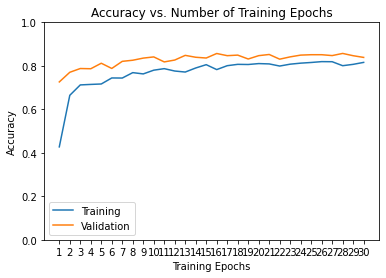

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_hist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### 3.8. Save the trained model 


In [ ]:
model_path = '/content/drive/My Drive/dl_model_v2_4inf.sav'
# model_path = os.getcwd()+'/dl_model_v2_4inf.sav'
torch.save(model_ft.state_dict(), model_path)

### 3.9. Save label/index pairs consistent to the model

In [ ]:
import pandas as pd

labels_path = '/content/drive/My Drive/dl_model_v2_labels.csv'
# labels_path = os.getcwd()+'/dl_model_v2_labels.csv'

def save_labels(labels_path):
    """
    Save the mapping between labels and index in the model (i.e. exists in ImageFolder) in a csv file
    """
    labels_dict = image_datasets['train'].class_to_idx
    labels_df = pd.DataFrame.from_dict(data=labels_dict, orient='index', columns=['idx'])
    labels_df['Label'] = labels_df.index # columns=['idx','Label']
    labels_df.reset_index(drop=True, inplace=True)
    labels_df.to_csv(labels_path, header=None, index=False)

save_labels(labels_path)